In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler

In [2]:
df_ercot = pd.read_csv("load_ercot_regions.csv")
df_ercot['ds']= pd.to_datetime(df_ercot['ds'])
df_ercot

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32
...,...,...,...,...,...,...,...,...,...
154849,2021-08-31 20:00:00,14477.26,1594.07,4307.99,832.71,13920.14,3666.45,7113.79,1150.02
154850,2021-08-31 21:00:00,14044.85,1565.64,4252.85,799.24,13308.33,3503.66,6805.93,1112.36
154851,2021-08-31 22:00:00,13796.10,1519.51,4213.14,777.39,12938.13,3396.58,6611.26,1086.27
154852,2021-08-31 23:00:00,13746.95,1498.90,4188.78,768.89,12876.06,3340.30,6589.14,1075.76


In [3]:
df_ercot.set_index('ds',inplace=True)
df_ercot=df_ercot.asfreq('1H')
df_ercot

,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
ds,,,,,,,,
2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32
...,...,...,...,...,...,...,...,...
2021-08-31 20:00:00,14477.26,1594.07,4307.99,832.71,13920.14,3666.45,7113.79,1150.02
2021-08-31 21:00:00,14044.85,1565.64,4252.85,799.24,13308.33,3503.66,6805.93,1112.36
2021-08-31 22:00:00,13796.10,1519.51,4213.14,777.39,12938.13,3396.58,6611.26,1086.27


In [4]:
# df_ercot = df_ercot.iloc[-10000:,:]

In [5]:
n_unit_size = 24
n_input_chunk = n_unit_size*20
n_output_chunk = n_unit_size*1
n_valid =  n_unit_size*60
n_test = n_unit_size*60
valid_iloc =n_input_chunk+n_valid+n_test
test_iloc = n_input_chunk+n_test

train_ts_list = [TimeSeries.from_series(df_ercot[col].iloc[:-valid_iloc],
                                        fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]
valid_ts_list = [TimeSeries.from_series(df_ercot[col].iloc[-valid_iloc:-test_iloc],
                                        fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]
test_ts_list = [TimeSeries.from_series(df_ercot[col].iloc[-test_iloc:],
                                       fill_missing_dates=False,fillna_value=0) for col in df_ercot.columns]

In [6]:
# train_ts_list

## 对不同地区进行建模

In [7]:
diqu = 7  #一共八个地区，分别为0-7

scaler = MinMaxScaler()
scaler_list = [Scaler(scaler) for col in df_ercot.columns]
train_ts_list_scaled = [s.fit_transform(t) for s,t in zip(scaler_list,train_ts_list)]
valid_ts_list_scaled = [s.transform(v) for s,v in zip(scaler_list,valid_ts_list)]
test_ts_list_scaled = [s.transform(v) for s,v in zip(scaler_list,test_ts_list)]


train_ts_list_scaled = train_ts_list_scaled[diqu]
valid_ts_list_scaled = valid_ts_list_scaled[diqu]
test_ts_list_scaled = test_ts_list_scaled[diqu]

In [8]:
# train_ts_list_scaled

## 开始建模

In [9]:
from darts.models import TCNModel,RandomForest,RNNModel,ARIMA


pl_trainer_kwargs={
     "accelerator": "gpu",
      "gpus": 1


    }
model = RNNModel(model="GRU",pl_trainer_kwargs=pl_trainer_kwargs,
                 input_chunk_length=n_input_chunk,
                 training_length=n_input_chunk+n_output_chunk, n_rnn_layers=2
                )

[2022-05-23 11:57:15,997] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
2022-05-23 11:57:15 darts.models WARNING: Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [10]:
# train = scaler_list[0].transform(df_ercot[0].iloc[:-test_iloc])
model.fit(train_ts_list_scaled,val_series=valid_ts_list_scaled,verbose=True,epochs=1,trainer=None)


[2022-05-23 11:57:16,096] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 151008 samples.
[2022-05-23 11:57:16,096] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 151008 samples.
2022-05-23 11:57:16 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 151008 samples.
[2022-05-23 11:57:16,099] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-23 11:57:16,099] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-23 11:57:16 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-05-23 11:57:16,101] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
pred = model.historical_forecasts( series=test_ts_list_scaled,verbose=False,retrain=False,
                                  start=n_input_chunk,forecast_horizon=n_output_chunk,stride=n_output_chunk,
                                  overlap_end=True,last_points_only =False)
pred_df = pd.concat([pred[s].pd_series() for s in range(len(pred))])


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 4719it [00:00, ?it/s]

In [12]:
pred_df = pd.concat([pred[s].pd_series() for s in range(len(pred))])

In [13]:
test_df = pd.concat([pred_df,test_ts_list_scaled.pd_series()],axis=1).iloc[n_input_chunk:,:]
test_df.columns = [f'yhat',f'y']
# test_all_df = pd.concat([test_all_df,test_df],axis=1)

In [14]:
test_df

,yhat,y
ds,,
2021-07-03 01:00:00,0.521028,0.521479
2021-07-03 02:00:00,0.540571,0.532748
2021-07-03 03:00:00,0.565339,0.557094
2021-07-03 04:00:00,0.593498,0.590521
2021-07-03 05:00:00,0.622899,0.630311
...,...,...
2021-08-31 20:00:00,0.517820,0.543128
2021-08-31 21:00:00,0.514906,0.525342
2021-08-31 22:00:00,0.516366,0.513021


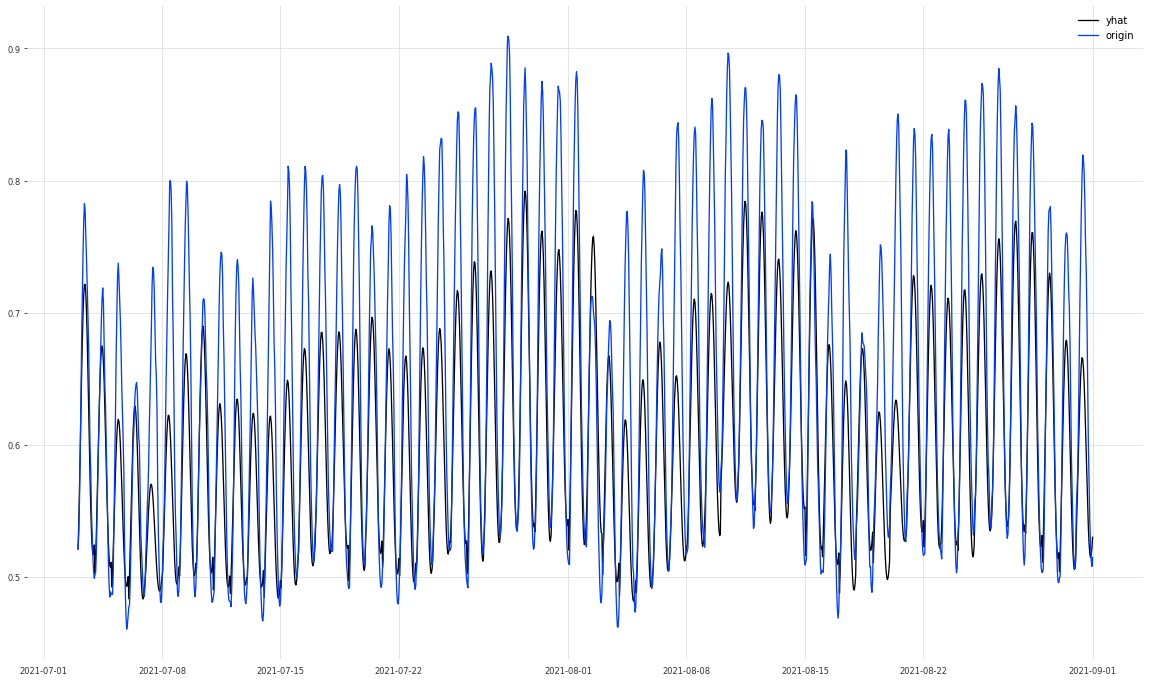

In [15]:
plt.figure(figsize=(20,12))
plt.plot(test_df.index,test_df.yhat,label='yhat')
plt.plot(test_df.index,test_df.y,label='origin')
plt.legend()

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
MSE = mean_squared_error(test_df.y, test_df.yhat)
MAE = mean_absolute_error(test_df.y, test_df.yhat)
MAPE = mean_absolute_percentage_error(test_df.y, test_df.yhat)
print(df_ercot.columns[diqu])
print("MSE=",MSE)
print("MAE=",MAE)
print("MAPE=",MAPE)

WEST
MSE= 0.005376992012119803
MAE= 0.05451171940145647
MAPE= 0.07612547452963456


In [17]:
# data = pd.read_csv("../其他模型/result/result.csv",index_col=0)
# data

In [18]:
# data_new = pd.concat([data,test_df.reset_index(drop=True)['yhat']],axis=1)
# data_new.rename(columns={"yhat":'GRU'},inplace=True)
# data_new

In [19]:
# data_new.to_csv("./result/result.csv")